In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os

In [3]:
from notebooks.preprocessing import preprocess_aso_data
from notebooks.consts import UPDATED_CSV

aso_df = preprocess_aso_data(UPDATED_CSV)

Preprocessing complete. Final valid rows: 29987


In [4]:
from tauso.data.data import load_db

db = load_db()

In [5]:
from tauso.data.data import get_data_dir
from tauso.data.consts import CELL_LINE_TO_DEPMAP
from tauso.features.codon_usage.find_cai_reference import load_cell_line_transcriptomes


data_dir = get_data_dir()
expression_dir = os.path.join(data_dir, "processed_expression")

# 2. Run the Optimized Loader
#    This loads the DB/FASTA once, filters for valid genes, and enriches sequences.
transcriptomes = load_cell_line_transcriptomes(
    cell_map=CELL_LINE_TO_DEPMAP,
    db=db,
    expression_dir=expression_dir,       # Directory containing expression CSVs
    filter_mode='non_mt',
    add_transcript=False
)

Querying GTF database for non_mt genes...


In [6]:
from tauso.features.off_target.get_premRNA_sequences import general_exp_data
from tauso.data.data import get_data_dir
from pathlib import Path

mean_exp_data = general_exp_data(Path(get_data_dir()) / 'OmicsExpressionTPMLogp1HumanAllGenesStranded.csv', db, filter_mode='non_mt')

Querying GTF database for non_mt genes...
Filtering: Kept 38585 genes out of 41144 total columns.


In [7]:
transcriptomes['general'] = mean_exp_data

In [8]:
from tauso.genome.read_human_genome import get_locus_to_data_dict

gene_to_data = get_locus_to_data_dict(include_introns=True)

Elapsed DB:  0.0004525184631347656
Elapsed Fasta:  0.0004525184631347656
Length:  3267117988


In [9]:
from tauso.features.off_target.off_target_feature import add_depmap_id_column
from tauso.data.consts import CELL_LINE_TO_DEPMAP

aso_df = add_depmap_id_column(aso_df, CELL_LINE_TO_DEPMAP)


In [11]:
from tauso.features.off_target.add_off_target_feat import AggregationMethod
from tauso.features.off_target.off_target_feature import run_off_target_pipeline_general

aso_df, features = run_off_target_pipeline_general(
    ASO_df=aso_df,
    gene_to_data=gene_to_data,
    cell_line2data=transcriptomes,
    top_n_list=[25],
    cutoff_list=[1300], method=AggregationMethod.ARTM_log
)

Running config: TopN=25, Cutoff=1300


In [13]:
from notebooks.features.feature_extraction import save_feature

for feature in features:
    save_feature(aso_df, feature)

Overwrote feature: off_target_score_general_ARTM_log_n25_c1300


In [73]:
from tauso.features.off_target.RNaseH1_off_target import off_target_specific_seq

cutoffs = [0, 200, 400, 600, 800, 1000, 1200]


results = []
for cutoff in cutoffs:
    df, feat_name = off_target_specific_seq(aso_df, 'RNASEH1', gene_to_data, cutoff=cutoff)
    results.append((df, feat_name))

In [66]:
for cutoff in cutoffs:
    df, feat_name = off_target_specific_seq(aso_df, 'ACTB', gene_to_data, cutoff=cutoff)
    results.append((df, feat_name))

c0
c200
c400
c600
c800
c1000
c1200


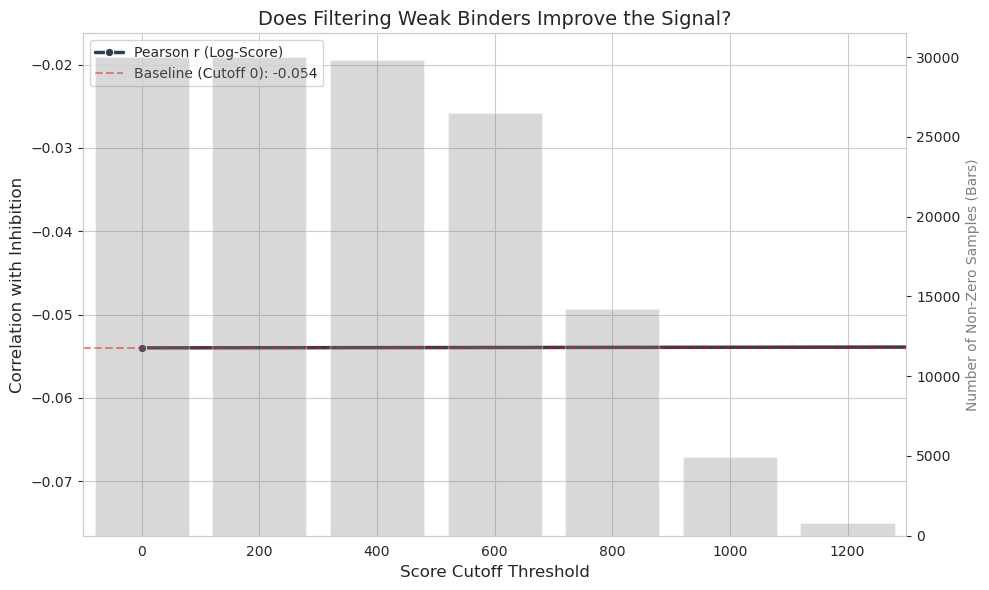

   Cutoff                          Feature  N_samples  Pearson_r       P_value
0       0     off_target_single_RNASEH1_c0      29987  -0.054004  8.115149e-21
1     200   off_target_single_RNASEH1_c200      29987  -0.051187  7.356489e-19
2     400   off_target_single_RNASEH1_c400      29834  -0.035806  6.157383e-10
3     600   off_target_single_RNASEH1_c600      26470  -0.037873  7.102557e-10
4     800   off_target_single_RNASEH1_c800      14185  -0.057415  7.746345e-12
5    1000  off_target_single_RNASEH1_c1000       4930  -0.018981  1.826997e-01
6    1200  off_target_single_RNASEH1_c1200        814  -0.073819  3.522776e-02


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Define your target column name
# (Replace with the actual variable from your consts if different)
target_col = INHIBITION

def analyze_cutoffs(results_list, gene_label):
    stats = []

    for df_feat, feat_name in results_list:
        # 1. Merge with the main dataframe to get Inhibition data
        # Assuming df_feat has 'index' or 'aso_id' and the score column
        # and aso_df has the target.
        # If df_feat ALREADY has inhibition, you can skip the merge.

        # Robust merge just in case:
        if target_col not in df_feat.columns:
            merged = aso_df.merge(df_feat, on='index', how='inner')
        else:
            merged = df_feat.copy()

        try:
            print(feat_name.split('_')[-1])
            cutoff_val = int(feat_name.split('_')[-1][1:])
        except:
            cutoff_val = cutoff # Fallback

        # 3. Log Transform for Fairness
        # We compare Log-Score because we know it works best
        score_col = feat_name
        merged['log_score'] = np.log1p(merged[score_col])

        # 4. Calculate Stats
        # We use the NON-ZERO samples to see if the filtered set is better
        subset = merged[merged['log_score'] > 0]
        n = len(subset)

        if n > 20:
            r_p, p_p = pearsonr(subset['log_score'], subset[target_col])
            r_s, p_s = spearmanr(subset['log_score'], subset[target_col])
        else:
            r_p, p_p, r_s, p_s = 0, 1, 0, 1

        stats.append({
            'Cutoff': cutoff_val,
            'Feature': feat_name,
            'N_samples': n,
            'Pearson_r': r_p,
            'Spearman_rho': r_s,
            'P_value': p_p
        })

    return pd.DataFrame(stats).sort_values('Cutoff')

# --- RUN ANALYSIS ---
# NOTE: Run this on your 'results' list
df_stats = analyze_cutoffs(results, "Current_Gene")

# --- PLOTTING ---
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot Pearson Correlation vs Cutoff
sns.lineplot(data=df_stats, x='Cutoff', y='Pearson_r', marker='o',
             color='#2c3e50', linewidth=2.5, label='Pearson r (Log-Score)')

# Add a reference line for "No Cutoff" baseline
baseline = df_stats.iloc[0]['Pearson_r']
ax1.axhline(baseline, color='red', linestyle='--', alpha=0.5, label=f'Baseline (Cutoff 0): {baseline:.3f}')

ax1.set_xlabel('Score Cutoff Threshold', fontsize=12)
ax1.set_ylabel('Correlation with Inhibition', fontsize=12)
ax1.set_title(f'Does Filtering Weak Binders Improve the Signal?', fontsize=14)
ax1.legend(loc='upper left')

# Secondary axis for Sample Size
ax2 = ax1.twinx()
sns.barplot(data=df_stats, x='Cutoff', y='N_samples', alpha=0.3, color='gray', ax=ax2)
ax2.set_ylabel('Number of Non-Zero Samples (Bars)', fontsize=10, color='gray')
ax2.grid(False)

plt.tight_layout()
plt.show()

# Print Table
print(df_stats[['Cutoff', 'Feature', 'N_samples', 'Pearson_r', 'P_value']])

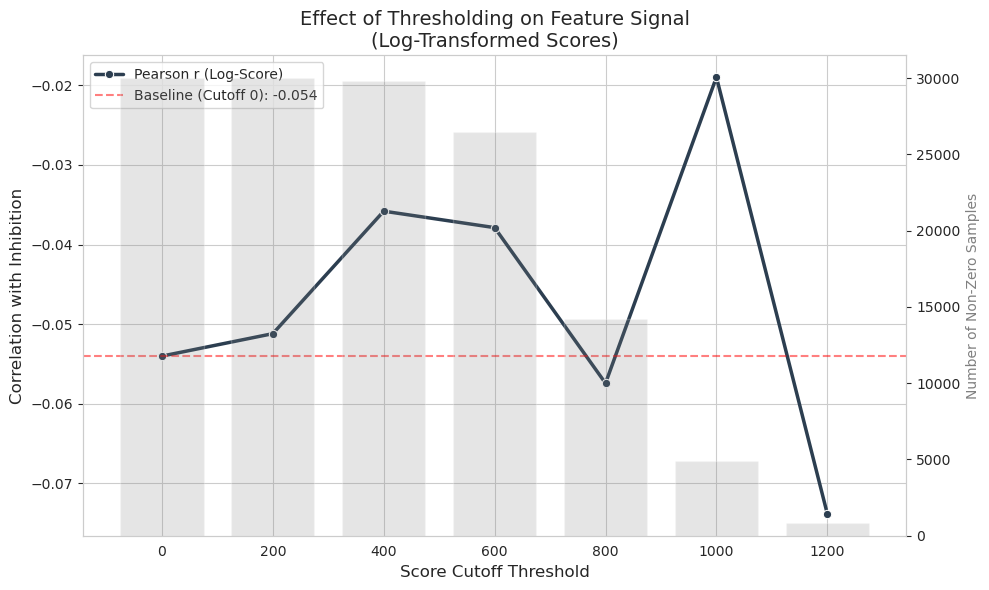

 Cutoff  N_samples  Pearson_r      P_value
      0      29987  -0.054004 8.115149e-21
    200      29987  -0.051187 7.356489e-19
    400      29834  -0.035806 6.157383e-10
    600      26470  -0.037873 7.102557e-10
    800      14185  -0.057415 7.746345e-12
   1000       4930  -0.018981 1.826997e-01
   1200        814  -0.073819 3.522776e-02


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Replace with your actual target column name constant
target_col = INHIBITION

def analyze_cutoffs(results_list, gene_label):
    stats = []

    for df_feat, feat_name in results_list:
        # 1. Merge with the main dataframe to get Inhibition data
        # Check if we need to merge or if inhibition is already there
        if target_col not in df_feat.columns:
            # robust merge on your ID column (usually 'index' or 'aso_id')
            merged = aso_df.merge(df_feat, on='index', how='inner')
        else:
            merged = df_feat.copy()

        # 2. Parse Cutoff from feature name (e.g., "..._c200" -> 200)
        try:
            # Split by '_', take last part ('c200'), remove 'c', convert to int
            cutoff_str = feat_name.split('_')[-1]
            cutoff_val = int(cutoff_str.replace('c', ''))
        except (ValueError, IndexError):
            # Fallback if naming convention fails
            print(f"Warning: Could not parse cutoff from '{feat_name}'. Defaulting to 0.")
            cutoff_val = 0

        # 3. Log Transform for Fairness
        # We compare Log-Score because we verified it works best (Linear Energy relationship)
        # Use log1p to safely handle zeros
        merged['log_score'] = np.log1p(merged[feat_name])

        # 4. Calculate Stats
        # We look at NON-ZERO samples.
        # (If we include zeros, the cutoff=200 vs cutoff=400 distinction is blurred
        # because both have tons of zeros. We want to see the quality of the "survivors")
        subset = merged[merged['log_score'] > 0]
        n = len(subset)

        if n > 20:
            r_p, p_p = pearsonr(subset['log_score'], subset[target_col])
            r_s, p_s = spearmanr(subset['log_score'], subset[target_col])
        else:
            r_p, p_p, r_s, p_s = 0, 1, 0, 1 # Valid fallback for empty/tiny sets

        stats.append({
            'Cutoff': cutoff_val,
            'Feature': feat_name,
            'N_samples': n,
            'Pearson_r': r_p,
            'Spearman_rho': r_s,
            'P_value': p_p
        })

    return pd.DataFrame(stats).sort_values('Cutoff')

# --- RUN ANALYSIS ---
# Pass the list of (df, feat_name) tuples you generated
df_stats = analyze_cutoffs(results, "Target_Gene_Analysis")

# --- PLOTTING ---
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

# 1. Line Plot (Correlation) - The Primary Metric
sns.lineplot(data=df_stats, x='Cutoff', y='Pearson_r', marker='o',
             color='#2c3e50', linewidth=2.5, label='Pearson r (Log-Score)', ax=ax1)

# Add baseline reference (Cutoff 0)
baseline = df_stats.iloc[0]['Pearson_r']
ax1.axhline(baseline, color='red', linestyle='--', alpha=0.5, label=f'Baseline (Cutoff 0): {baseline:.3f}')

ax1.set_xlabel('Score Cutoff Threshold', fontsize=12)
ax1.set_ylabel('Correlation with Inhibition', fontsize=12)
ax1.set_title(f'Effect of Thresholding on Feature Signal\n(Log-Transformed Scores)', fontsize=14)
ax1.legend(loc='upper left')

# 2. Bar Plot (Sample Size) - on Secondary Axis
ax2 = ax1.twinx()
# Note: We align the barplot by treating Cutoff as numeric
ax2.bar(df_stats['Cutoff'], df_stats['N_samples'],
        width=150, alpha=0.2, color='gray', label='Sample Size')
ax2.set_ylabel('Number of Non-Zero Samples', fontsize=10, color='gray')
ax2.grid(False)

plt.tight_layout()
plt.show()

# Print Clean Table
print(df_stats[['Cutoff', 'N_samples', 'Pearson_r', 'P_value']].to_string(index=False))

In [71]:
df_stats.columns

Index(['Cutoff', 'Feature', 'N_samples', 'Pearson_r', 'Spearman_rho',
       'P_value'],
      dtype='object')

In [56]:
from notebooks.consts import INHIBITION

In [60]:
result1, feat_name1 = result1
result2, feat_name2 = result2

CORRELATION ANALYSIS (LOG TRANSFORMED):

--- RNaseH1 (Log-Space) ---
Non-Zero Samples: 26348
Correlation (r):  -0.0357
P-value:          7.00e-09
------------------------------
--- ACTB (Log-Space) ---
Non-Zero Samples: 26807
Correlation (r):  -0.0456
P-value:          8.28e-14
------------------------------


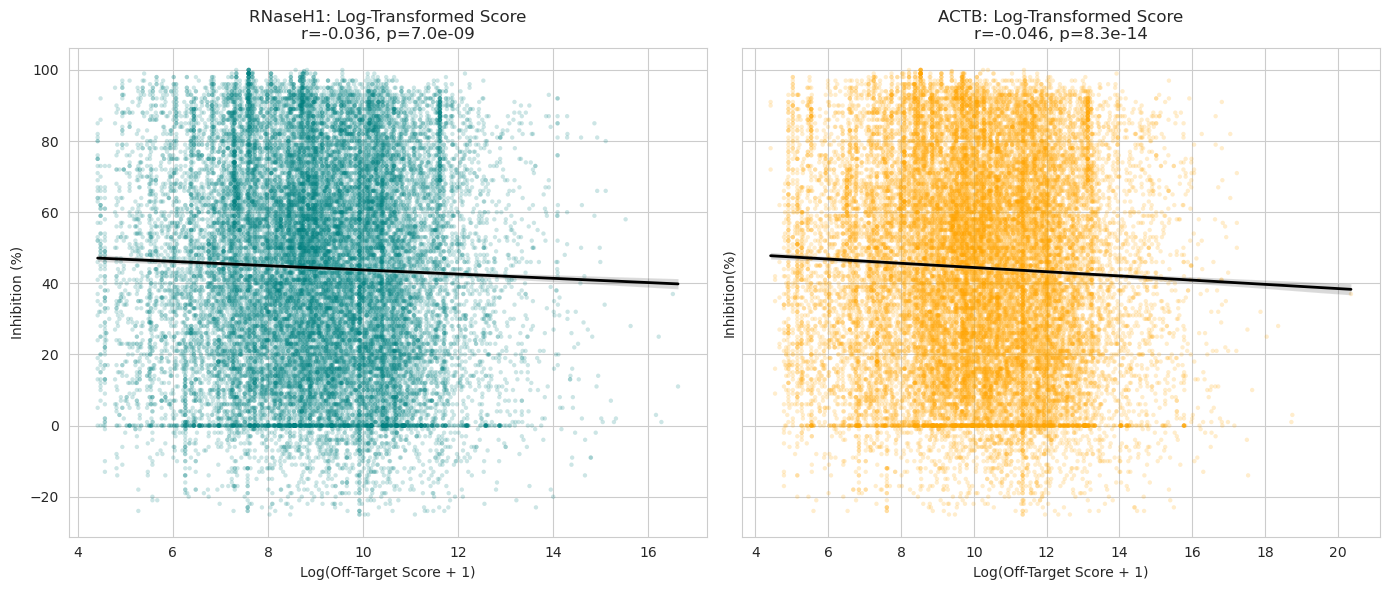

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# ---------------------------------------------------------
# 1. ROBUST MERGE & TRANSFORM
# ---------------------------------------------------------
id_col = 'index' # Change to 'aso_id' if needed

# Prepare subsets
r1 = result1[[id_col, 'off_target_single_RNASEH1_c600']].rename(columns={'off_target_single_RNASEH1_c600': 'score_rnaseh1'})
r2 = result2[[id_col, 'off_target_single_ACTB_c600']].rename(columns={'off_target_single_ACTB_c600': 'score_actb'})

# Merge
df_plot = aso_df.merge(r1, on=id_col, how='inner').merge(r2, on=id_col, how='inner')

# Clean outliers in inhibition
df_clean = df_plot[df_plot[INHIBITION].between(-25, 125)].copy()

# *** KEY CHANGE: Log-Transform the Features ***
# We use log1p (log(1+x)) to handle zeros gracefully
df_clean['log_rnase'] = np.log1p(df_clean['score_rnaseh1'])
df_clean['log_actb']  = np.log1p(df_clean['score_actb'])

# ---------------------------------------------------------
# 2. STATS CALCULATION (On Logged Features)
# ---------------------------------------------------------
def print_log_stats(name, df, x_col, y_col):
    # Filter for non-zero original scores (which means log_score > 0)
    # This avoids the clump of zeros skewing the regression line
    df_nz = df[df[x_col] > 0]

    if len(df_nz) < 10:
        return 0, 1.0

    r_nz, p_nz = pearsonr(df_nz[x_col], df_nz[y_col])

    print(f"--- {name} (Log-Space) ---")
    print(f"Non-Zero Samples: {len(df_nz)}")
    print(f"Correlation (r):  {r_nz:.4f}")
    print(f"P-value:          {p_nz:.2e}")
    print("-" * 30)
    return r_nz, p_nz

print("CORRELATION ANALYSIS (LOG TRANSFORMED):\n")
r_rnase_log, p_rnase_log = print_log_stats("RNaseH1", df_clean, 'log_rnase', INHIBITION)
r_actb_log, p_actb_log   = print_log_stats("ACTB",    df_clean, 'log_actb',  INHIBITION)

# ---------------------------------------------------------
# 3. PLOT (Linear Scale on Logged Data)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.set_style("whitegrid")

# Plot 1: RNaseH1
# Filter for >0 to avoid the "Zero Anchor" at x=0
filt_rnase = df_clean[df_clean['log_rnase'] > 0]

sns.regplot(data=filt_rnase, x='log_rnase', y=INHIBITION, ax=axes[0],
            scatter_kws={'alpha': 0.2, 's': 10, 'color': 'teal', 'edgecolor': 'none'},
            line_kws={'color': 'black', 'linewidth': 2})

axes[0].set_title(f'RNaseH1: Log-Transformed Score\nr={r_rnase_log:.3f}, p={p_rnase_log:.1e}')
axes[0].set_xlabel('Log(Off-Target Score + 1)')
axes[0].set_ylabel('Inhibition (%)')

# Plot 2: ACTB
filt_actb = df_clean[df_clean['log_actb'] > 0]

sns.regplot(data=filt_actb, x='log_actb', y=INHIBITION, ax=axes[1],
            scatter_kws={'alpha': 0.2, 's': 10, 'color': 'orange', 'edgecolor': 'none'},
            line_kws={'color': 'black', 'linewidth': 2})

axes[1].set_title(f'ACTB: Log-Transformed Score\nr={r_actb_log:.3f}, p={p_actb_log:.1e}')
axes[1].set_xlabel('Log(Off-Target Score + 1)')

plt.tight_layout()
plt.show()

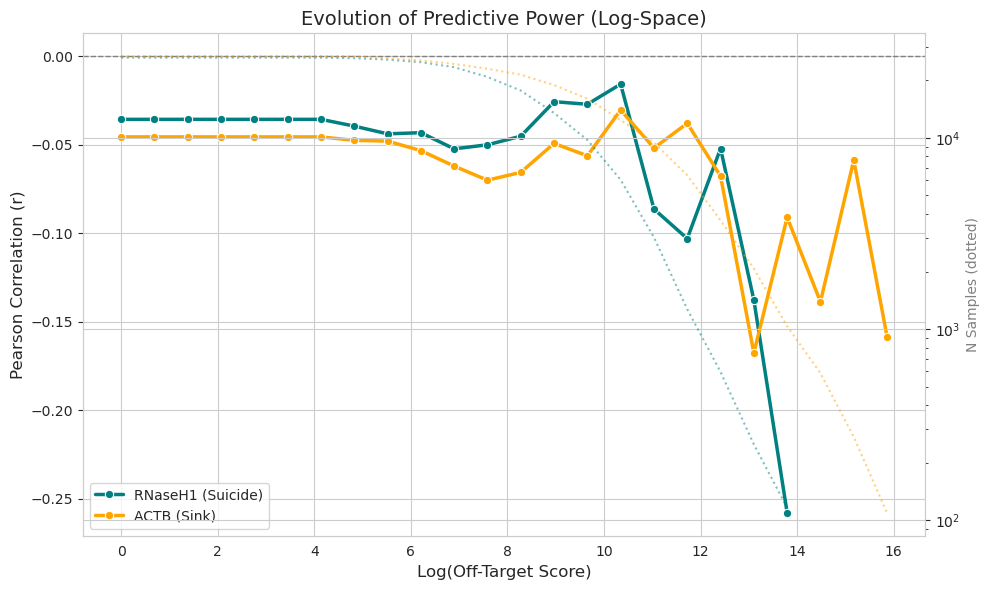

--- RNaseH1 Peak (Log Space) ---
Log_Threshold         13.793103
Raw_Equivalent    977841.065029
N_samples            116.000000
Correlation           -0.257874
P_value                0.005194
Name: 20, dtype: float64

--- ACTB Peak (Log Space) ---
Log_Threshold     1.310345e+01
Raw_Equivalent    4.906303e+05
N_samples         2.068000e+03
Correlation      -1.675974e-01
P_value           1.703318e-14
Name: 19, dtype: float64


In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ---------------------------------------------------------
# 1. PREPARE LOG DATA
# ---------------------------------------------------------
# (Assuming df_clean is already merged from previous steps)
# If not, ensure you run the merge block first.

# Create Log-Transformed Columns (Pseudo-Energy)
df_clean['log_rnase'] = np.log1p(df_clean['score_rnaseh1'])
df_clean['log_actb']  = np.log1p(df_clean['score_actb'])

# ---------------------------------------------------------
# 2. SCANNING FUNCTION (Updated for Log inputs)
# ---------------------------------------------------------
def scan_log_thresholds(df, log_score_col, target_col, thresholds):
    results = []

    for t in thresholds:
        # Filter: Keep scores higher than the current log-threshold
        subset = df[df[log_score_col] > t]
        n = len(subset)

        if n > 50: # Maintain statistical validity
            # Calculate correlation on the LOGGED values
            r, p = pearsonr(subset[log_score_col], subset[target_col])
            results.append({
                'Log_Threshold': t,
                'Raw_Equivalent': np.expm1(t), # For reference
                'N_samples': n,
                'Correlation': r,
                'P_value': p
            })
        else:
            break

    return pd.DataFrame(results)

# Define Thresholds in Log-Space (0 to 20 covers roughly 1 to 5e8 raw score)
log_thresholds = np.linspace(0, 20, num=30)

# Run the Scan
res_rnase_log = scan_log_thresholds(df_clean, 'log_rnase', INHIBITION, log_thresholds)
res_actb_log  = scan_log_thresholds(df_clean, 'log_actb',  INHIBITION, log_thresholds)

# ---------------------------------------------------------
# 3. PLOT
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot Correlation Curves
sns.lineplot(data=res_rnase_log, x='Log_Threshold', y='Correlation', marker='o',
             label='RNaseH1 (Suicide)', color='teal', ax=ax1, linewidth=2.5)
sns.lineplot(data=res_actb_log,  x='Log_Threshold', y='Correlation', marker='o',
             label='ACTB (Sink)',    color='orange', ax=ax1, linewidth=2.5)

# Formatting
# Note: We use linear scale for X because the units are already Log
ax1.set_xlabel('Log(Off-Target Score)', fontsize=12)
ax1.set_ylabel('Pearson Correlation (r)', fontsize=12)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
ax1.set_title('Evolution of Predictive Power (Log-Space)', fontsize=14)

# Secondary Axis for Sample Size
ax2 = ax1.twinx()
sns.lineplot(data=res_rnase_log, x='Log_Threshold', y='N_samples', color='teal',
             linestyle=':', ax=ax2, alpha=0.5, legend=False)
sns.lineplot(data=res_actb_log,  x='Log_Threshold', y='N_samples', color='orange',
             linestyle=':', ax=ax2, alpha=0.5, legend=False)
ax2.set_ylabel('N Samples (dotted)', fontsize=10, color='gray')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. PRINT PEAKS
# ---------------------------------------------------------
print("--- RNaseH1 Peak (Log Space) ---")
# Find the row with the most negative correlation (strongest effect)
print(res_rnase_log.loc[res_rnase_log['Correlation'].idxmin()])

print("\n--- ACTB Peak (Log Space) ---")
print(res_actb_log.loc[res_actb_log['Correlation'].idxmin()])

In [26]:
merged_df = pd.merge(aso_df, result1, on='index', how='inner')

In [27]:

merged_df[merged_df['off_target_score'] != 0]['off_target_score'].corr(merged_df[INHIBITION])

np.float64(-0.018319959136363258)

In [22]:
from notebooks.consts import INHIBITION

merged_df[merged_df['off_target_score'] != 0]['off_target_score'].corr(merged_df[INHIBITION])

np.float64(-0.07366937134534392)

In [28]:
from scipy import stats

filtered_df = merged_df[merged_df['off_target_score'] != 0]
stats.pearsonr(filtered_df['off_target_score'], filtered_df[INHIBITION])

PearsonRResult(statistic=np.float64(-0.018319959136363258), pvalue=np.float64(0.24629121820992264))

In [24]:
from scipy import stats

filtered_df = merged_df[merged_df['off_target_score'] != 0]
stats.pearsonr(filtered_df['off_target_score'], filtered_df[INHIBITION])

PearsonRResult(statistic=np.float64(-0.07366937134534386), pvalue=np.float64(0.0005298178492176215))

In [20]:
result[result['off_target_score'] != 0]

,index,off_target_score
6,6,20918.725631
12,12,20918.725631
29,29,20918.725631
944,946,11651.614115
955,959,6902.231196
...,...,...
29939,36842,14806.060607
29963,36866,14806.060607
29975,36878,14806.060607
29977,36880,14806.060607


In [ ]:
df = pd.read_csv('off_target.ARTM_log.specific.top50.cutoff1200.csv')

In [ ]:
from notebooks.consts import INHIBITION

feat = 'off_target_score_specific_ARTM_log_n50_c1200'
correlation = df[feat].corr(aso_df[INHIBITION])

print(f"Correlation: {correlation}")

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 1. Align the dataframes on the 'index' column
merged_df = pd.merge(
    df[['index', feat]],
    aso_df[['index', INHIBITION]],
    on='index'
).dropna(subset=[feat, INHIBITION])

col_feature = feat
col_target = INHIBITION

# 2. Function to get correlation and p-value
def get_stats(data, label):
    corr, p_value = pearsonr(data[col_feature], data[col_target])
    print(f"--- {label} ---")
    print(f"Correlation: {corr:.4f}")
    print(f"P-value:     {p_value:.4e}")
    print(f"Sample Size: {len(data)}\n")
    return corr, p_value

# Full Dataset Correlation
get_stats(merged_df, "Full Dataset")

# 3. Filter for non-zero features
filtered_df = merged_df[merged_df[col_feature] != 0]
get_stats(filtered_df, f"Filtered (where {col_feature} != 0)")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Align and Merge
merged_df = pd.merge(
    df[['index', feat]],
    aso_df[['index', INHIBITION]],
    on='index'
).dropna()

# 2. Create the non-zero subset
filtered_df = merged_df[merged_df[feat] != 0]

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Left Plot: Full Dataset
sns.regplot(
    data=merged_df,
    x=feat,
    y=INHIBITION,
    ax=axes[0],
    scatter_kws={'alpha': 0.2, 's': 10, 'color': 'gray'},
    line_kws={'color': 'blue', 'label': 'Full Set (r=0.106)'}
)
axes[0].set_title("Full Dataset (N=8395)\nSignificant due to large sample size", fontsize=14)
axes[0].legend()

# Right Plot: Non-Zero Only
sns.regplot(
    data=filtered_df,
    x=feat,
    y=INHIBITION,
    ax=axes[1],
    scatter_kws={'alpha': 0.5, 's': 20, 'color': 'teal'},
    line_kws={'color': 'red', 'label': 'Non-Zero Set (r=0.053)'}
)
axes[1].set_title("Filtered (Non-Zero, N=474)\nNot statistically significant", fontsize=14)
axes[1].legend()

plt.suptitle("Correlation Analysis: Off-Target Score vs. Inhibition", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()